In [1]:
# imports
import pandas as pd
import os, ipdb, re
import random, evaluate
import string
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from datasets import DatasetDict, Dataset, load_dataset
import wandb
import ast
import re, os
import subprocess

from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

/nfs/home/kabenamualus/anaconda3/envs/tdm/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# # dataset_path = "../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_ALL_TEMPLATE/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_50_PERCENT/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_LONG/fold1"
# # dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_50_PERCENT_DOCTEAT/fold1"
# dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_NO_TEMPLATE_DOCTEAT/fold1"

# dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
# dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

In [3]:
def calculate_fuzz_ratio(text1, text2):
    return fuzz.ratio(str(text1).strip().lower(), str(text2).strip().lower())

def view_leaderboard_distribution(dfs):

    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_train = dfs['train'].copy()
    dfs_validation = dfs['validation'].copy()

    dfs_train['leaderboard'] = dfs_train.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_train = dfs_train['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_train, labels=counts_train.index, autopct='%1.1f%%', startangle=140)
    plt.title('Train Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_validation['leaderboard'] = dfs_validation.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts_validation = dfs_validation['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts_validation, labels=counts_validation.index, autopct='%1.1f%%', startangle=140)
    plt.title('Validation Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    dfs_zeroshot['leaderboard'] = dfs_zeroshot.answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    # Count unique values in the column
    counts = dfs_zeroshot['leaderboard'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 8))  # Optional: Adjusts the size of the figure
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Zeroshot Chart Leaderboard vs No Leaderboard')
    plt.show()
    
    
def verify_data_integrity_old(dfs):

    zeroshot_paper_in_train = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['train'].id.to_list():
            zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    for paper in dfs['zeroshot'].id.unique():
        if paper in dfs['validation'].id.to_list():
            zeroshot_paper_in_validation += 1 

    train_paper_in_validation = 0
    for paper in dfs['train'].id.unique():
        if paper in dfs['validation'].id.to_list():
            train_paper_in_validation += 1   
        
    validation_paper_in_zeroshot = 0
    for paper in dfs['validation'].id.unique():
        if paper in dfs['zeroshot'].id.to_list():
            validation_paper_in_zeroshot += 1     
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"train_paper_in_validation: {train_paper_in_validation}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def verify_data_integrity(dfs, include_no_lb=True):

    zeroshot_paper_in_train = 0
    dfs_train = dfs['train'].copy()
    dfs_train.drop_duplicates(subset='id', inplace=True)
    dfs_validation = dfs['validation'].copy()
    dfs_validation.drop_duplicates(subset='id', inplace=True)
    dfs_zeroshot = dfs['zeroshot'].copy()
    dfs_zeroshot.drop_duplicates(subset='id', inplace=True)
    
    records_zero_train = dfs_zeroshot.to_dict("records")    
    for row in records_zero_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                zeroshot_paper_in_train += 1
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_train += 1
        
    zeroshot_paper_in_validation = 0
    records_zero_val = dfs_zeroshot.to_dict("records")
    for row in records_zero_val:
        if include_no_lb:
            if row['id'] in dfs_validation['id'].to_list():
                zeroshot_paper_in_validation += 1 
        else:
            if row['id'] in dfs_validation['id'].to_list() and row['leaderboard']!="no_lb":
                zeroshot_paper_in_validation += 1 

    validation_paper_in_train = 0
    records_val_train = dfs_validation.to_dict("records")
    for row in records_val_train:
        if include_no_lb:
            if row['id'] in dfs_train['id'].to_list():
                validation_paper_in_train += 1   
        else:
            if row['id'] in dfs_train['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_train += 1   
        
    validation_paper_in_zeroshot = 0
    records_train_zero = dfs_validation.to_dict("records")
    for row in records_train_zero:
            
        if include_no_lb:
            if row['id'] in dfs_zeroshot['id'].to_list():
                validation_paper_in_zeroshot += 1     
        else:
            if row['id'] in dfs_zeroshot['id'].to_list() and row['leaderboard']!="no_lb":
                validation_paper_in_zeroshot += 1   
            
    print(f"zeroshot_paper_in_train: {zeroshot_paper_in_train}")
    print(f"zeroshot_paper_in_validation: {zeroshot_paper_in_validation}")
    print(f"validation_paper_in_train: {validation_paper_in_train}")
    print(f"validation_paper_in_zeroshot: {validation_paper_in_zeroshot}")
    
def remove_data_leakage_old(dfs, source, target, THRESHOLD=90):
    papers_to_drop = []
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    source_records = dfs[source].to_dict("records")

    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        
        for leaderboard_source in source_tdms:
            
            if to_drop_paper_found:
                break
            
            source_task = leaderboard_source["LEADERBOARD"]["Task"]
            source_dataset = leaderboard_source["LEADERBOARD"]["Dataset"]
            source_metric = leaderboard_source["LEADERBOARD"]["Metric"]
            source_score = leaderboard_source["LEADERBOARD"]["Score"]
 
            dfs[target].drop_duplicates(subset='id', inplace=True)
            
            target_records = dfs[target].to_dict("records")

            for target_row in target_records:
                
                if to_drop_paper_found:
                        break    
                
                target_paper_id = target_row["id"]
                target_tdms = target_row["answer"]
                
                if target_tdms == "unanswerable" or target_tdms == "missed":
                    # ipdb.set_trace()
                    continue 
                
                target_tdms = ast.literal_eval(target_row["answer"])
                
                
                for leaderboard_target in target_tdms:
                    target_task = leaderboard_target["LEADERBOARD"]["Task"]
                    target_dataset = leaderboard_target["LEADERBOARD"]["Dataset"]
                    target_metric = leaderboard_target["LEADERBOARD"]["Metric"]
                    target_score = leaderboard_target["LEADERBOARD"]["Score"]
                    
                    # A) Exact 
                    if (source_task == target_task and source_dataset == target_dataset and source_metric == target_metric) or (target_paper_id == source_paper_id):
                        if source_paper_id not in papers_to_drop:
                            papers_to_drop.append(source_paper_id)
                        to_drop_paper_found = True 
                        break
    
                    # # B) Partial  or # A) Exact 
                    # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
                    #     if paper_id not in papers_to_drop:
                    #         papers_to_drop.append(paper_id)
                    #         # ipdb.set_trace()
                    #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage_id(dfs, source, target, THRESHOLD=90):
    papers_to_drop = set()
    missed_parsing_zero = 0
    
    dfs[source].drop_duplicates(subset='id', inplace=True)
    records = dfs[source].to_dict("records")

    for row in tqdm(records, total=len(records)):
        to_drop_paper_found = False 
        source_paper_id = row["id"]
        
        dfs[target].drop_duplicates(subset='id', inplace=True)
        target_records = dfs[target].to_dict("records")

        for row_target in target_records:  
            
            target_paper_id = row_target["id"]
            
            # A) Exact 
            if (target_paper_id == source_paper_id):
                papers_to_drop.add(source_paper_id)
                to_drop_paper_found = True 
                break
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target}: {len(papers_to_drop)}")        
    
    return papers_to_drop


def remove_data_leakage(dfs, source, target, THRESHOLD=90):
    papers_to_drop = {"id": set(), "tdm":set()}
    missed_parsing_zero = 0
    
    dfs_target = dfs[target].drop_duplicates(subset='id')
    unique_paper_id_target = dfs_target.id.unique()
    lists_target = [ast.literal_eval(lb) for lb in dfs_target[dfs_target.leaderboard =="lb"].answer.to_list()]
    # Flatten the list of lists
    flattened_list_target = [item for sublist in lists_target for item in sublist]
    # Extract unique tuples
    unique_tuples_target = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in flattened_list_target}


    dfs_source = dfs[source].drop_duplicates(subset='id')
    source_records = dfs_source.to_dict("records")
    for source_row in tqdm(source_records, total=len(source_records)):
        to_drop_paper_found = False 
        source_paper_id = source_row["id"]
        source_tdms = source_row["answer"]
        
        if source_paper_id in unique_paper_id_target:
            papers_to_drop["id"].add(source_paper_id)
            continue     
        
        if source_tdms in "unanswerable" or source_tdms == "missed":
            # ipdb.set_trace()
            # if source_paper_id not in papers_to_drop:
            #     papers_to_drop.append(source_paper_id)
            continue 
        
        source_tdms = ast.literal_eval(source_row["answer"])
        # Extract unique tuples
        unique_tuples_source = {(d['LEADERBOARD']['Task'], d['LEADERBOARD']['Dataset'], d['LEADERBOARD']['Metric']) for d in source_tdms} 
        
        is_contained = unique_tuples_source.issubset(unique_tuples_target)
    
        if is_contained:
            papers_to_drop["tdm"].add(source_paper_id)
            
      
        
        # # B) Partial  or # A) Exact 
        # if (calculate_fuzz_ratio(train_task, zeroshot_task) >= THRESHOLD and calculate_fuzz_ratio(train_dataset, zeroshot_dataset) >= THRESHOLD and calculate_fuzz_ratio(train_metric, zeroshot_metric) >= THRESHOLD) or (train_task == zeroshot_task and train_dataset == zeroshot_dataset and train_metric == zeroshot_metric):
        #     if paper_id not in papers_to_drop:
        #         papers_to_drop.append(paper_id)
        #         # ipdb.set_trace()
        #         break 
                    
    print(f"Missed_parsing_zero {missed_parsing_zero}") 
    print(f"Lenght papers_to_drop in {source} based on {target} Title ID: {len(papers_to_drop['id'])}") 
    print(f"Lenght papers_to_drop in {source} based on {target} TDM Match: {len(papers_to_drop['tdm'])}")   

    print(f"Lenght papers from {source} with lb: {len(dfs_source[dfs_source['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {source} with no_lb: {len(dfs_source[dfs_source['leaderboard']=='no_lb'])}") 
    print(f"Lenght papers from {target} with lb: {len(dfs_target[dfs_target['leaderboard']=='lb'])}") 
    print(f"Lenght papers from {target} with no_lb: {len(dfs_target[dfs_target['leaderboard']=='no_lb'])}") 
    
    
    return papers_to_drop

## DOCTEAT ALL TEMPLATES

In [4]:
dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_ZEROSHOT_TDMS_ALL_TEMPLATE_DOCTEAT/fold1"

dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
    
dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}

dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")

In [5]:
dfs['train'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,150870,150870,150870,150870,150870
unique,10058,150053,7016,15,2
top,1707.03497v2.pdf,Author Guidelines for ECCV Submission The abst...,unanswerable,drop_7,lb
freq,15,7,45495,10065,105375


In [6]:
dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,20205,20205,20205,20205,20205
unique,1347,20202,903,15,2
top,1810.02575v1.pdf,Context: Incorporating Glosses into Neural Wor...,unanswerable,drop_7,lb
freq,15,2,6660,1350,13545


In [7]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,13890,13890,13890,13890,13890
unique,926,13888,574,15,2
top,2209.03182v1.pdf,Context: Applications of the Gauss-Jordan algo...,unanswerable,drop_7,lb
freq,15,2,5295,928,8595


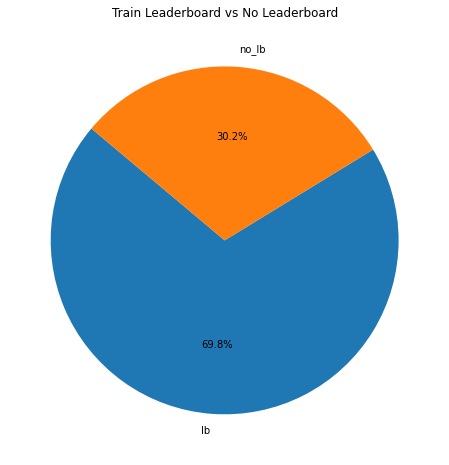

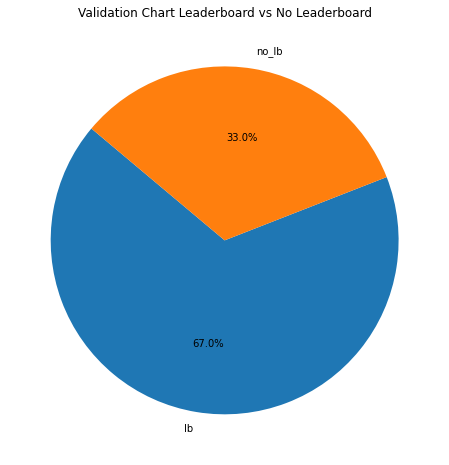

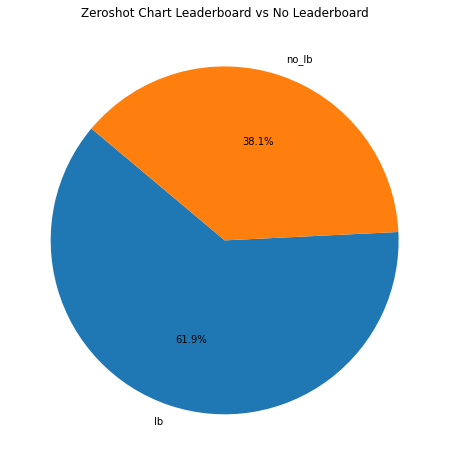

In [8]:
view_leaderboard_distribution(dfs)

In [9]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 926/926 [00:00<00:00, 9774.18it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8088.13it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [10]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,13890,13890,13890,13890,13890
unique,926,13888,574,15,2
top,2209.03182v1.pdf,Context: Applications of the Gauss-Jordan algo...,unanswerable,drop_7,lb
freq,15,2,5295,928,8595


In [11]:
print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
print(f"len(dfs['validation']): {len(dfs['validation'])}")

len(dfs['zeroshot']): 13890
len(dfs['validation']): 20205
len(dfs['zeroshot']): 6120
len(dfs['validation']): 20205


In [12]:
dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,6120,6120,6120,6120,6120
unique,408,6119,56,15,2
top,2004.13665v2.pdf,Context: Applications of the Gauss-Jordan algo...,unanswerable,drop_7,no_lb
freq,15,2,5295,409,5295


In [13]:
# In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
# At least one of the leaderboard was not seen at training time 
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)

print("\nvalidation\n")
# in validation this means paper to keep as part of few shot 
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 408/408 [00:00<00:00, 10707.25it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8093.70it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [14]:
zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
print(f"len(zeroshot_concat): {len(zeroshot_concat)}")
# zeroshot_concat = dfs['zeroshot']
# print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
print(f"len(validation_concat): {len(validation_concat)}")

len(zeroshot_concat): 9750
len(validation_concat): 20865


In [15]:
# Filtering the DataFrame
dfs['zeroshot'] = zeroshot_concat.copy()

dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]

dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,9090,9090,9090,9090,9090
unique,595,8924,243,15,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_7,no_lb
freq,30,2,5295,607,5295


In [16]:
# Filtering the DataFrame
dfs['validation'] = validation_concat.copy()
# I want to keep all the no leaderboard papers in validation 
dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]

dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,17235,17235,17235,17235,17235
unique,1105,16572,661,15,2
top,2005.07150v3.pdf,Read this: Named Entity Recognition as Depende...,unanswerable,drop_7,lb
freq,30,2,6660,1152,10575


In [17]:
zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
print("\nvalidation\n")
validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)

100%|██████████| 595/595 [00:00<00:00, 9199.32it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8460.97it/s]

Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033


In [18]:
dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

In [19]:
dfs['train'].tail()

,id,prompt,answer,template,prompt lenght,leaderboard
150865,1111.2942.pdf,Down the Rabbit Hole: Robust Proximity Search ...,unanswerable,drop_3,231,no_lb
150866,1111.2942.pdf,Down the Rabbit Hole: Robust Proximity Search ...,unanswerable,drop_4,234,no_lb
150867,1111.2942.pdf,Read this article and answer this question Dow...,unanswerable,drop_5,238,no_lb
150868,1111.2942.pdf,Down the Rabbit Hole: Robust Proximity Search ...,unanswerable,drop_6,239,no_lb
150869,1111.2942.pdf,Context: Down the Rabbit Hole: Robust Proximit...,unanswerable,drop_7,234,no_lb


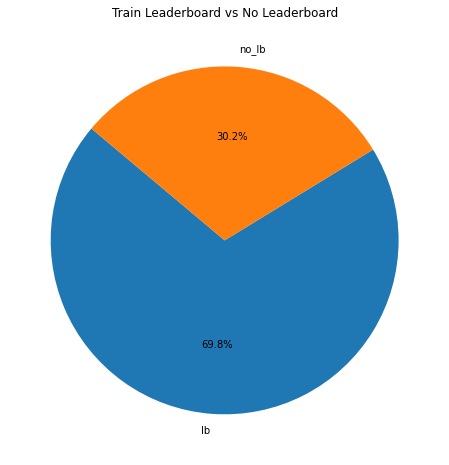

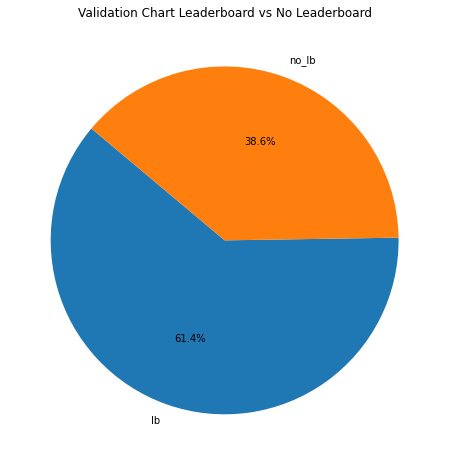

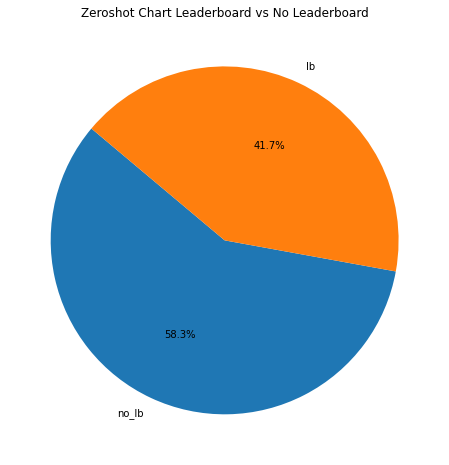

In [20]:
view_leaderboard_distribution(dfs)

In [21]:
verify_data_integrity(dfs, include_no_lb=False)

zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


In [22]:
dfs['zeroshot'].drop(["prompt lenght"], axis=1).describe()

,id,prompt,answer,template,leaderboard
count,9090,9090,9090,9090,9090
unique,595,8924,243,15,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_7,no_lb
freq,30,2,5295,607,5295


In [23]:
dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

dataset.save_to_disk("../data/LEADERBOARDS_DOCTEAT_TDMS_ALL_TEMPLATES")

Saving the dataset (0/2 shards):   0%|          | 0/150870 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17235 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9090 [00:00<?, ? examples/s]

### Templates Specific

In [24]:
for squad_id in range(1, 9):
    print(f"SQUAD: {squad_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_SQUAD_{squad_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")

    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")
    
    # In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
    # At least one of the leaderboard was not seen at training time 
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    # in validation this means paper to keep as part of few shot 
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
    print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

    validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
    print(f"len(validation_concat): {len(validation_concat)}")
    
    # Filtering the DataFrame
    dfs['zeroshot'] = zeroshot_concat.copy()
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]
    # dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    # Filtering the DataFrame
    dfs['validation'] = validation_concat.copy()
    # I want to keep all the no leaderboard papers in validation 
    dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]
    # dfs['validation'].drop_duplicates(subset='id', inplace=True)
    dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

    # no leaderboard paper can be shared between few-shot and zero-shot
    verify_data_integrity(dfs, include_no_lb=False)
    
    display(dfs['zeroshot'].drop(["prompt lenght"], axis=1).describe())
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_SQUAD_{squad_id}")

SQUAD: 1

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5775.47it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 4801.15it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10575.71it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8048.06it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8950.97it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8539.90it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_1,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

SQUAD: 2

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11902.34it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7966.62it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10639.88it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8078.06it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8897.10it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8159.51it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this and answer the question. If the ques...,unanswerable,squad_2,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

SQUAD: 3

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11537.63it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7713.33it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 9804.27it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7466.13it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8358.04it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8225.61it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_3,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

SQUAD: 4

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5894.61it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7939.43it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10588.07it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8003.47it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8890.99it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8459.59it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_4,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

SQUAD: 5

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5730.75it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7613.51it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 9488.80it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 4647.16it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8412.64it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 7992.75it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_5,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

SQUAD: 6

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5859.66it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8068.63it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10565.39it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8048.78it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8800.81it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8507.01it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,squad_6,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

SQUAD: 7

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11678.91it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8063.74it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10535.79it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8135.18it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9082.21it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8333.76it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this: SharinGAN: Combining Synthetic and ...,unanswerable,squad_7,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

SQUAD: 8

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5853.20it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 4153.17it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 8840.38it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8023.05it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 6968.33it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8474.67it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this: SharinGAN: Combining Synthetic and ...,unanswerable,squad_8,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

In [25]:
for drop_id in range(1, 8):
    print(f"DROP: {drop_id}")
    dataset_path = f"../data/LLLM_AUGMENTED_SUMMARIZED_WITH_ID_ZEROSHOT_TDMS_DROP_{drop_id}_DOCTEAT/fold1"

    dataset_dict = DatasetDict.load_from_disk(f"{dataset_path}")
        
    dfs = {split: dataset.to_pandas() for split, dataset in dataset_dict.items()}
    dfs['train']['leaderboard'] = dfs['train'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['validation']['leaderboard'] = dfs['validation'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    dfs['zeroshot']['leaderboard'] = dfs['zeroshot'].answer.apply(lambda x: "no_lb" if x == "unanswerable" else "lb")
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")

    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['id'])]
    dfs['validation'] = dfs['validation'][~dfs['validation']['id'].isin(validation_papers_to_drop['id'])]

    print(f"len(dfs['zeroshot']): {len(dfs['zeroshot'])}")
    print(f"len(dfs['validation']): {len(dfs['validation'])}")
    
    # In zeroshot means paper to remove from zero-shot to make it real zershot, in the sense that 
    # At least one of the leaderboard was not seen at training time 
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    # in validation this means paper to keep as part of few shot 
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    zeroshot_concat = pd.concat([dfs['zeroshot'], dfs['validation'][~(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) & (dfs['validation']['leaderboard']=="lb")]], ignore_index=True)
    print(f"len(zeroshot_concat): {len(zeroshot_concat)}")

    validation_concat = pd.concat([dfs['validation'], dfs['zeroshot'][dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]], ignore_index=True)
    print(f"len(validation_concat): {len(validation_concat)}")
    
    # Filtering the DataFrame
    dfs['zeroshot'] = zeroshot_concat.copy()
    dfs['zeroshot'] = dfs['zeroshot'][~dfs['zeroshot']['id'].isin(zeroshot_papers_to_drop['tdm'])]
    # dfs['zeroshot'].drop_duplicates(subset='id', inplace=True)
    dfs['zeroshot'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    # Filtering the DataFrame
    dfs['validation'] = validation_concat.copy()
    # I want to keep all the no leaderboard papers in validation 
    dfs['validation'] = dfs['validation'][(dfs['validation']['id'].isin(validation_papers_to_drop['tdm'])) | (dfs['validation']['leaderboard']=="no_lb")]
    # dfs['validation'].drop_duplicates(subset='id', inplace=True)
    dfs['validation'].drop(["prompt lenght", "__index_level_0__"], axis=1).describe()
    
    print("\nZeroshot\n")
    zeroshot_papers_to_drop = remove_data_leakage(dfs, source="zeroshot", target="train", THRESHOLD=90)
    print("\nvalidation\n")
    validation_papers_to_drop = remove_data_leakage(dfs, source="validation", target="train", THRESHOLD=90)
    
    dfs['train'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['validation'].drop(["__index_level_0__"], inplace=True, axis=1)
    dfs['zeroshot'].drop(["__index_level_0__"], inplace=True, axis=1)

    # no leaderboard paper can be shared between few-shot and zero-shot
    verify_data_integrity(dfs, include_no_lb=False)
    
    display(dfs['zeroshot'].drop(["prompt lenght"], axis=1).describe())
    
    dataset = DatasetDict({
        "train": Dataset.from_pandas(dfs['train']),
        "validation": Dataset.from_pandas(dfs['validation']),
        "zeroshot": Dataset.from_pandas(dfs['zeroshot'])
    })

    dataset.save_to_disk(f"../data/LEADERBOARDS_DOCTEAT_TDMS_DROP_{drop_id}")

DROP: 1

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5812.30it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7956.04it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10570.28it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7994.43it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8858.32it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8196.65it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,Answer based on context:\n\nSharinGAN: Combini...,unanswerable,drop_1,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

DROP: 2

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5873.11it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7896.17it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10531.71it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7912.57it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8935.23it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8462.57it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_2,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

DROP: 3

Zeroshot



100%|██████████| 924/924 [00:00<00:00, 11477.02it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 517
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 572
Lenght papers from zeroshot with no_lb: 352
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032

validation



100%|██████████| 1344/1344 [00:00<00:00, 7941.49it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 659
Lenght papers from validation with lb: 901
Lenght papers from validation with no_lb: 443
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032
len(dfs['zeroshot']): 924
len(dfs['validation']): 1344
len(dfs['zeroshot']): 407
len(dfs['validation']): 1344

Zeroshot



100%|██████████| 407/407 [00:00<00:00, 10575.60it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 352
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032

validation



100%|██████████| 1344/1344 [00:00<00:00, 4628.43it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 659
Lenght papers from validation with lb: 901
Lenght papers from validation with no_lb: 443
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032
len(zeroshot_concat): 649
len(validation_concat): 1388

Zeroshot



100%|██████████| 594/594 [00:00<00:00, 8942.98it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 352
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032

validation



100%|██████████| 1102/1102 [00:00<00:00, 8481.75it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 659
Lenght papers from validation with lb: 659
Lenght papers from validation with no_lb: 443
Lenght papers from train with lb: 7019
Lenght papers from train with no_lb: 3032
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,605,605,605,605,605
unique,594,594,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_3,no_lb
freq,2,2,352,605,352


Saving the dataset (0/1 shards):   0%|          | 0/10051 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1146 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/605 [00:00<?, ? examples/s]

DROP: 4

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11651.12it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7860.29it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 8373.54it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7624.41it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8635.09it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8487.63it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_4,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

DROP: 5

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 11670.87it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7883.98it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10440.08it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7769.00it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 8513.72it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8416.56it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,Read this article and answer this question Sha...,unanswerable,drop_5,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

DROP: 6

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5863.40it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7640.49it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 926
len(dfs['validation']): 1347
len(dfs['zeroshot']): 408
len(dfs['validation']): 1347

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 9734.72it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 7935.72it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 650
len(validation_concat): 1391

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9114.16it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8590.39it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,606,606,606,606,606
unique,595,595,243,1,2
top,2006.04026v1.pdf,SharinGAN: Combining Synthetic and Real Data f...,unanswerable,drop_6,no_lb
freq,2,2,353,606,353


Saving the dataset (0/1 shards):   0%|          | 0/10058 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/606 [00:00<?, ? examples/s]

DROP: 7

Zeroshot



100%|██████████| 926/926 [00:00<00:00, 5916.05it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 518
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 573
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8106.46it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(dfs['zeroshot']): 928
len(dfs['validation']): 1350
len(dfs['zeroshot']): 409
len(dfs['validation']): 1350

Zeroshot



100%|██████████| 408/408 [00:00<00:00, 10773.52it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 44
Lenght papers from zeroshot with lb: 55
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1347/1347 [00:00<00:00, 8171.56it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 903
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
len(zeroshot_concat): 651
len(validation_concat): 1394

Zeroshot



100%|██████████| 595/595 [00:00<00:00, 9012.03it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in zeroshot based on train Title ID: 0
Lenght papers_to_drop in zeroshot based on train TDM Match: 0
Lenght papers from zeroshot with lb: 242
Lenght papers from zeroshot with no_lb: 353
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033

validation



100%|██████████| 1105/1105 [00:00<00:00, 8574.66it/s]


Missed_parsing_zero 0
Lenght papers_to_drop in validation based on train Title ID: 0
Lenght papers_to_drop in validation based on train TDM Match: 661
Lenght papers from validation with lb: 661
Lenght papers from validation with no_lb: 444
Lenght papers from train with lb: 7025
Lenght papers from train with no_lb: 3033
zeroshot_paper_in_train: 0
zeroshot_paper_in_validation: 0
validation_paper_in_train: 0
validation_paper_in_zeroshot: 0


,id,prompt,answer,template,leaderboard
count,607,607,607,607,607
unique,595,595,243,1,2
top,2006.04026v1.pdf,Context: SharinGAN: Combining Synthetic and Re...,unanswerable,drop_7,no_lb
freq,2,2,354,607,354


Saving the dataset (0/1 shards):   0%|          | 0/10065 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1152 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/607 [00:00<?, ? examples/s]